# Modelisation Cbow
Accès au dossier du projet sur Google Drive

In [1]:
import sys
import os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive/', force_remount=True)
    %cd drive/MyDrive/nov23_bds_rakuten
else:
    root_files = os.listdir()
    if not "requirements.txt" in root_files:
        print("The jupyter server root should be set to root of git project")
        print("If you're on vscode add the following to your settings.json file")
        print('"jupyter.notebookFileRoot": "${workspaceFolder}"')

Mounted at /content/drive/
/content/drive/.shortcut-targets-by-id/1_2JJeYhhAHn4xWGD5kC2VtjM-_SxznEm/nov23_bds_rakuten


Import des librairies

In [2]:
!pip install gensim

In [14]:
import pandas as pd
import numpy as np

from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

from joblib import dump, load

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Chargement du fichier source output/data-exploration/X_train_pre.csv.

Fichier contenant le texte nettoyé, mais avec le contexte (le sens) pour CBOW

In [4]:
df_train = pd.read_csv('output/data-preprocessing-resampling/df_train.csv', index_col=0)
display(df_train.head())
df_test = pd.read_csv('output/data-preprocessing-resampling/df_test.csv', index_col=0)
display(df_test.head())

y_train = pd.DataFrame(df_train['prdtypecode'])
y_train.columns = ['prdtypecode']
display(y_train.head())
y_test = pd.DataFrame(df_test['prdtypecode'])
y_test.columns = ['prdtypecode']
display(y_test.head())

# Vérifier les dimensions des DataFrames après suppression
print("Dimensions de df_train :", df_train.shape)
print("Dimensions de y_train  :", y_train.shape)
print("Dimensions de df_test :", df_test.shape)
print("Dimensions de y_test  :", y_test.shape)

,productid,imageid,text,lang,text_fr,imagezoomed,prdtypecode
0,131641431,885888766,Jesus - Cahiers Du Libre Avenir - Prêtre autre...,fr,Jesus - Cahiers Du Libre Avenir - Prêtre autre...,False,10
1,745789761,1304710852,The Inglorious Arts Of Peace: Exhibitions In C...,en,Les arts de la paix sans gloire: expositions d...,False,10
2,651353882,1033554185,Lecons De Sciences - Cours Superieur - Premier...,fr,Lecons De Sciences - Cours Superieur - Premier...,False,10
3,4043473264,1306457352,Generations Of Women Historians -,en,Générations de femmes historiens -,False,10
4,679913105,1034656535,Oeuvres Dramatiques De F. Schiller Tome 6 -,fr,Oeuvres Dramatiques De F. Schiller Tome 6 -,False,10


,productid,imageid,text,lang,text_fr,imagezoomed,prdtypecode
index,,,,,,,
29927,3469563513,1215209457,Adventure Parks Heavy Duty Tree Strap - Dont t...,en,Les parcs d'aventure STRAP DURT DE DURG - N'at...,False,1280
42596,4152889175,1309607798,Magideal 2 Pcs Orff Instrument De Musique Hoch...,fr,Magideal 2 Pcs Orff Instrument De Musique Hoch...,False,1320
158,1190507078,1068211845,Casa Padrino Baroque Dining Room With Armrests...,en,Casa Padrino Baroque Dining Room avec des acco...,False,1560
20061,4236041996,1324088536,T6 Xml Zoomable Led Lampe De Poche Tactique + ...,fr,T6 Xml Zoomable Led Lampe De Poche Tactique + ...,False,1302
20931,3836739131,1250952042,Organisateur Enfants En Bois Keepsake Cadeau P...,fr,Organisateur Enfants En Bois Keepsake Cadeau P...,False,1280


,prdtypecode
0,10
1,10
2,10
3,10
4,10


,prdtypecode
index,
29927,1280
42596,1320
158,1560
20061,1302
20931,1280


Dimensions de df_train : (109566, 7)
Dimensions de y_train  : (109566, 1)
Dimensions de df_test : (8492, 7)
Dimensions de y_test  : (8492, 1)


In [5]:
# On ne garde que la colonne text pour la suite
X_train = pd.DataFrame()
X_train['text'] = df_train.text_fr
X_test = pd.DataFrame()
X_test['text'] = df_test.text_fr

In [6]:
display(X_train.head())
display(y_train.head())

,text
0,Jesus - Cahiers Du Libre Avenir - Prêtre autre...
1,Les arts de la paix sans gloire: expositions d...
2,Lecons De Sciences - Cours Superieur - Premier...
3,Générations de femmes historiens -
4,Oeuvres Dramatiques De F. Schiller Tome 6 -


,prdtypecode
0,10
1,10
2,10
3,10
4,10


# **Vectorisation** CBOW

Tokenisation de chaque phrase

In [7]:
# Tokenisation de chaque phrase
X_train['tokenized'] = X_train['text'].apply(word_tokenize)
X_test['tokenized'] = X_test['text'].apply(word_tokenize)

Vectorisation CBOW

In [8]:
# Vectorisation CBOW
model_cbow = Word2Vec(sentences = X_train['tokenized'].tolist(), vector_size = 100, window = 5, min_count = 1, sg = 0)

In [9]:
# Conversion des textes en vecteurs
def document_vector(doc):
    # Supprimer les mots qui ne sont pas dans le modèle
    doc = [word for word in doc if word in model_cbow.wv.key_to_index]
    return np.mean(model_cbow.wv[doc], axis=0) if doc else np.zeros(model_cbow.vector_size)

In [10]:
X_train_vectors = X_train['tokenized'].apply(document_vector)
X_test_vectors = X_test['tokenized'].apply(document_vector)

In [11]:
X_train_vectors.head()

0    [0.89962375, 0.5272418, 0.2815237, -0.36482686...
1    [1.8479183, -0.13590081, 0.022651756, 0.762629...
2    [0.4899916, 0.6774998, 1.0660759, -0.5392919, ...
3    [0.8214882, 0.5990554, 0.80212754, -0.09572549...
4    [0.17359959, 0.40641874, 1.0924658, -0.4910648...
Name: tokenized, dtype: object

# **Modélisation**

## RandomForestClassifier

### Entrainement du modèle rfc, puis stockage

In [24]:
modele_rfc = RandomForestClassifier(random_state=123)
modele_rfc.fit(np.array(X_train_vectors.tolist()), y_train)

# Faire des prédictions sur l'ensemble de test
y_pred_rfc = modele_rfc.predict(np.array(X_test_vectors.tolist()))

In [ ]:
# Enregistrer le modèle dans un fichier
dump(modele_rfc, 'c:/Users/Karim/datascientest/rakuten/output/data-modeling-text-1/modele_rfc.joblib')

['c:/Users/Karim/datascientest/rakuten/output/data-modeling-text-1/modele_rfc.joblib']

In [ ]:
# Code pour charger le modèle rfc
modele_rfc = load('c:/Users/Karim/datascientest/rakuten/output/data-modeling-text-1/modele_rfc.joblib')
# Faire des prédictions sur l'ensemble de test
y_pred_rfc = modele_rfc.predict(X_test_tfidf)

### Résultats du RFC

Ajout des labels de classe pour visu

In [21]:
prdcodetype2label = {
    10 : "Livre occasion",
    40 : "Jeu vidéo, accessoire tech.",
    50 : "Accessoire Console",
    60 : "Console de jeu",
    1140 : "Figurine",
    1160 : "Carte Collection",
    1180 : "Jeu Plateau",
    1280 : "Jouet enfant, déguisement",
    1281 : "Jeu de société",
    1300 : "Jouet tech",
    1301 : "Paire de chaussettes",
    1302 : "Jeu extérieur, vêtement",
    1320 : "Autour du bébé",
    1560 : "Mobilier intérieur",
    1920 : "Chambre",
    1940 : "Cuisine",
    2060 : "Décoration intérieure",
    2220 : "Animal",
    2280 : "Revues et journaux",
    2403 : "Magazines, livres et BDs",
    2462 : "Jeu occasion",
    2522 : "Bureautique et papeterie",
    2582 : "Mobilier extérieur",
    2583 : "Autour de la piscine",
    2585 : "Bricolage",
    2705 : "Livre neuf",
    2905 : "Jeu PC",
}



In [ ]:
y_test_visu = y_test['prdtypecode'].map(prdcodetype2label)
y_pred_visu = [prdcodetype2label.get(code, "Label") for code in y_pred_rfc]

Score du modèle : 0.6833490343853038


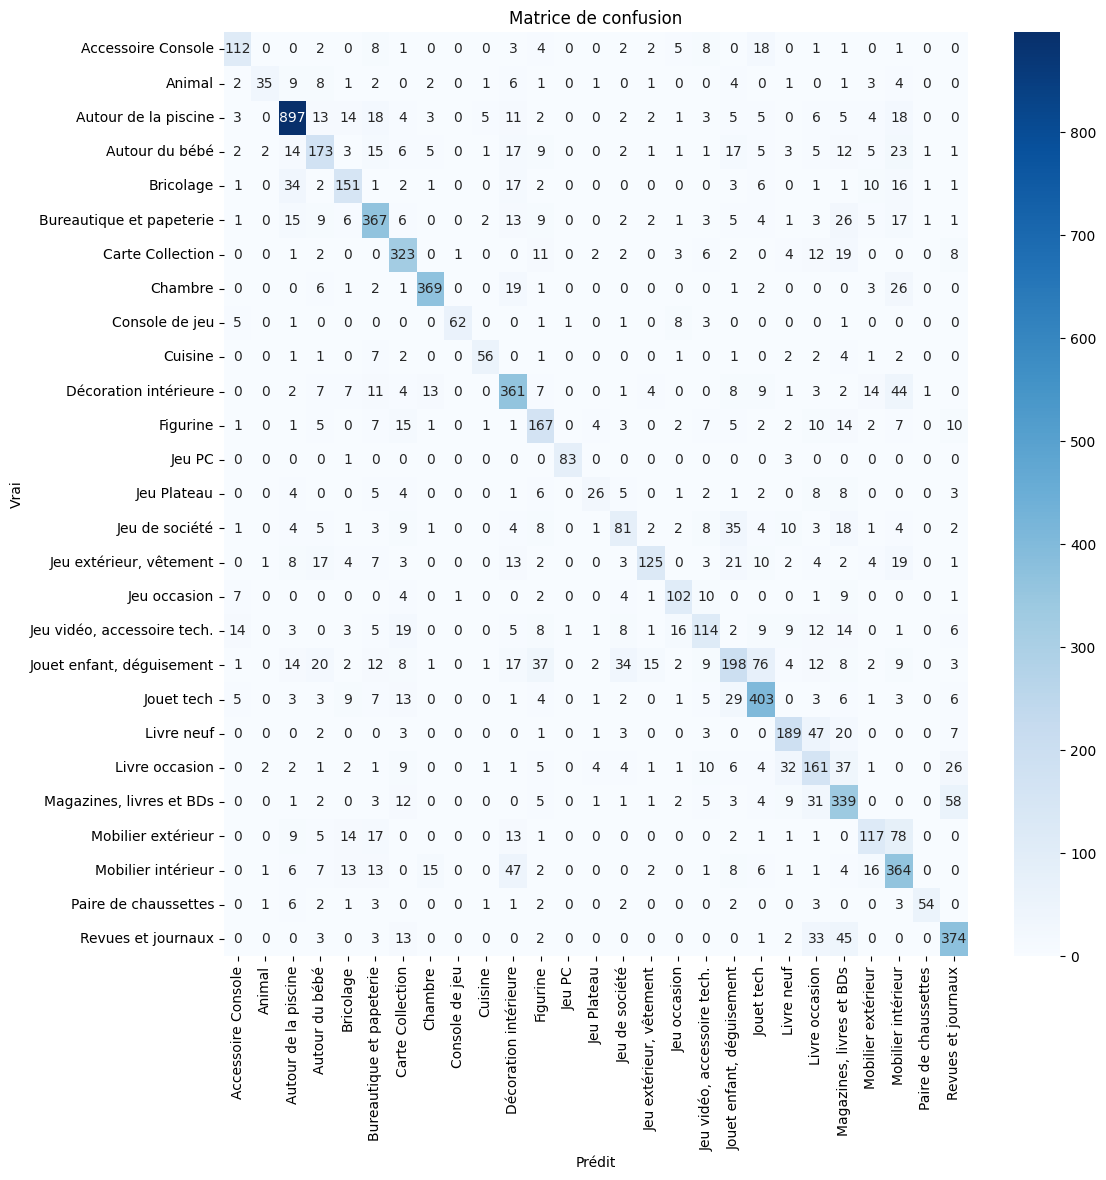

In [28]:
# Calculer le score du modèle
score = accuracy_score(y_test_visu, y_pred_visu)
print("Score du modèle :", score)

# Créer et afficher la matrice de confusion
mat_conf = pd.crosstab(y_test_visu, y_pred_visu)

plt.figure(figsize=(12, 12))
sns.heatmap(mat_conf, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion")
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.show()

In [29]:
print(classification_report(y_test_visu, y_pred_visu))

                             precision    recall  f1-score   support

         Accessoire Console       0.72      0.67      0.69       168
                     Animal       0.83      0.43      0.56        82
       Autour de la piscine       0.87      0.88      0.87      1021
             Autour du bébé       0.59      0.53      0.56       324
                  Bricolage       0.65      0.60      0.63       250
   Bureautique et papeterie       0.71      0.74      0.72       499
           Carte Collection       0.70      0.82      0.75       396
                    Chambre       0.90      0.86      0.88       431
             Console de jeu       0.97      0.75      0.84        83
                    Cuisine       0.81      0.69      0.75        81
      Décoration intérieure       0.66      0.72      0.69       499
                   Figurine       0.56      0.63      0.59       267
                     Jeu PC       0.98      0.95      0.97        87
                Jeu Plateau      

### Fonction pour faire des prédictions

In [30]:
def predict_modele_rfc(text):
    # Créer un DataFrame de test
    df_test = pd.DataFrame({'texte': [text]})
    # Vectorisation
    X_phrase = df_test['texte'].apply(document_vector)
    # Convertir X_phrase en un tableau numpy bidimensionnel
    X_phrase_array = np.vstack(X_phrase)
    # Prédiction
    y_phrase = modele_rfc.predict(X_phrase_array)

    return print("Prédiction pour le texte :", text, "\n ->", prdcodetype2label[y_phrase[0]])

Test de prédiction :

In [31]:
phrase = "Moakoada Congélateur Teether Sensorielle Jouet Pour 0 À 12 Mois Les Bébés - ABS congélateur Teether sensorielle Jouet pour 0 à 12 mois les bébés Présentation du produit: soulagez votre TEETHING BÉBÉ ET MALAISE DE LA DOULEUR - rehausseurs sont maman et de papa de lifesavers pendant l'étape de dentition. Ils fonctionnent comme des sucettes mais encore mieux avec les courbes et les textures qui massent les gencives de vos enfants et de stimuler la croissance de leurs dents. AIDER ENCOURAGER LE DÉVELOPPEMENT DU CERVEAU ET L'APPRENTISSAGE TACTILE - Chaque bébé a une teether conception colorée d'amusement et la texture qui fait vraiment bon pour bébé jouets sensorielles. Mis à part qu'ils sont amusants à jouer ils offrent également l'apprentissage visuel et tactile sans danger pour bébé. Ce jouet pour bébé sucette a une conception solide ou n'a pas de petites pièces à mordre il est certainement bébés. AVEC FONCTION CONÇU DANS L'ESPRIT - Le bébé jouet de dentition s'adapte parfaitement dans la bouche de votre bébé mais il est juste la bonne taille pour ne pas poser un risque d'étouffement. Les poignées sont conçus de sorte qu'ils peuvent être facilement saisis par les petites mains. La conception fonctionnelle rend également chaque teether très facile à nettoyer et à ranger. ABS matériau non toxique est adopté ce qui peut être bouillie à emballage haute température: un ensemble de 10 pièces de bébé Conseils Teether: Cuites à haute température pendant moins d'une demi-minute Ne pas utiliser l'eau froide pour refroidir immédiatement après la désinfection sinon il provoque une déformation du produit. sinon il causera la déformation du produit. sinon il causera la déformation du produit."
predict_modele_rfc(phrase)

phrase = "Lot de 8 préfiltres jetables pour panier de skimmer - Marina - Lots de 8 pré-filtres jetables de la marque Marina. Universels ils sont compatibles avec touts les paniers de skimmer mesurant jusqu'à 40 cm de diamètre."
predict_modele_rfc(phrase)

phrase = "Mario Kart 8 Deluxe Switch - Jeu video Nintendo Switch Bananes et carapaces sur place ou à emporter !"
predict_modele_rfc(phrase)

phrase = "du texte au pif avec une pelle pour faire penser au jardin"
predict_modele_rfc(phrase)

phrase = "Avec une pelle pour faire penser au jardin"
predict_modele_rfc(phrase)

phrase = "Avec une pelle près de la piscine pour faire penser au jardin"
predict_modele_rfc(phrase)

Prédiction pour le texte : Moakoada Congélateur Teether Sensorielle Jouet Pour 0 À 12 Mois Les Bébés - ABS congélateur Teether sensorielle Jouet pour 0 à 12 mois les bébés Présentation du produit: soulagez votre TEETHING BÉBÉ ET MALAISE DE LA DOULEUR - rehausseurs sont maman et de papa de lifesavers pendant l'étape de dentition. Ils fonctionnent comme des sucettes mais encore mieux avec les courbes et les textures qui massent les gencives de vos enfants et de stimuler la croissance de leurs dents. AIDER ENCOURAGER LE DÉVELOPPEMENT DU CERVEAU ET L'APPRENTISSAGE TACTILE - Chaque bébé a une teether conception colorée d'amusement et la texture qui fait vraiment bon pour bébé jouets sensorielles. Mis à part qu'ils sont amusants à jouer ils offrent également l'apprentissage visuel et tactile sans danger pour bébé. Ce jouet pour bébé sucette a une conception solide ou n'a pas de petites pièces à mordre il est certainement bébés. AVEC FONCTION CONÇU DANS L'ESPRIT - Le bébé jouet de dentition s

## GradientBoostingClassifier

### Entrainement du modèle gbc

In [35]:
modele_gbc = GradientBoostingClassifier(n_estimators = 100, learning_rate = 1.0, max_depth = 1, random_state = 0)
modele_gbc.fit(np.array(X_train_vectors.tolist()), y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)

In [40]:
# Faire des prédictions sur l'ensemble de test
y_pred_gbc = modele_gbc.predict(np.array(X_test_vectors.tolist()))

### Résultats du GBC

Ajout des labels de classe pour visu

In [41]:
y_test_visu = y_test['prdtypecode'].map(prdcodetype2label)
y_pred_visu = [prdcodetype2label.get(code, "Label") for code in y_pred_gbc]

Score du modèle : 0.3029910504003768


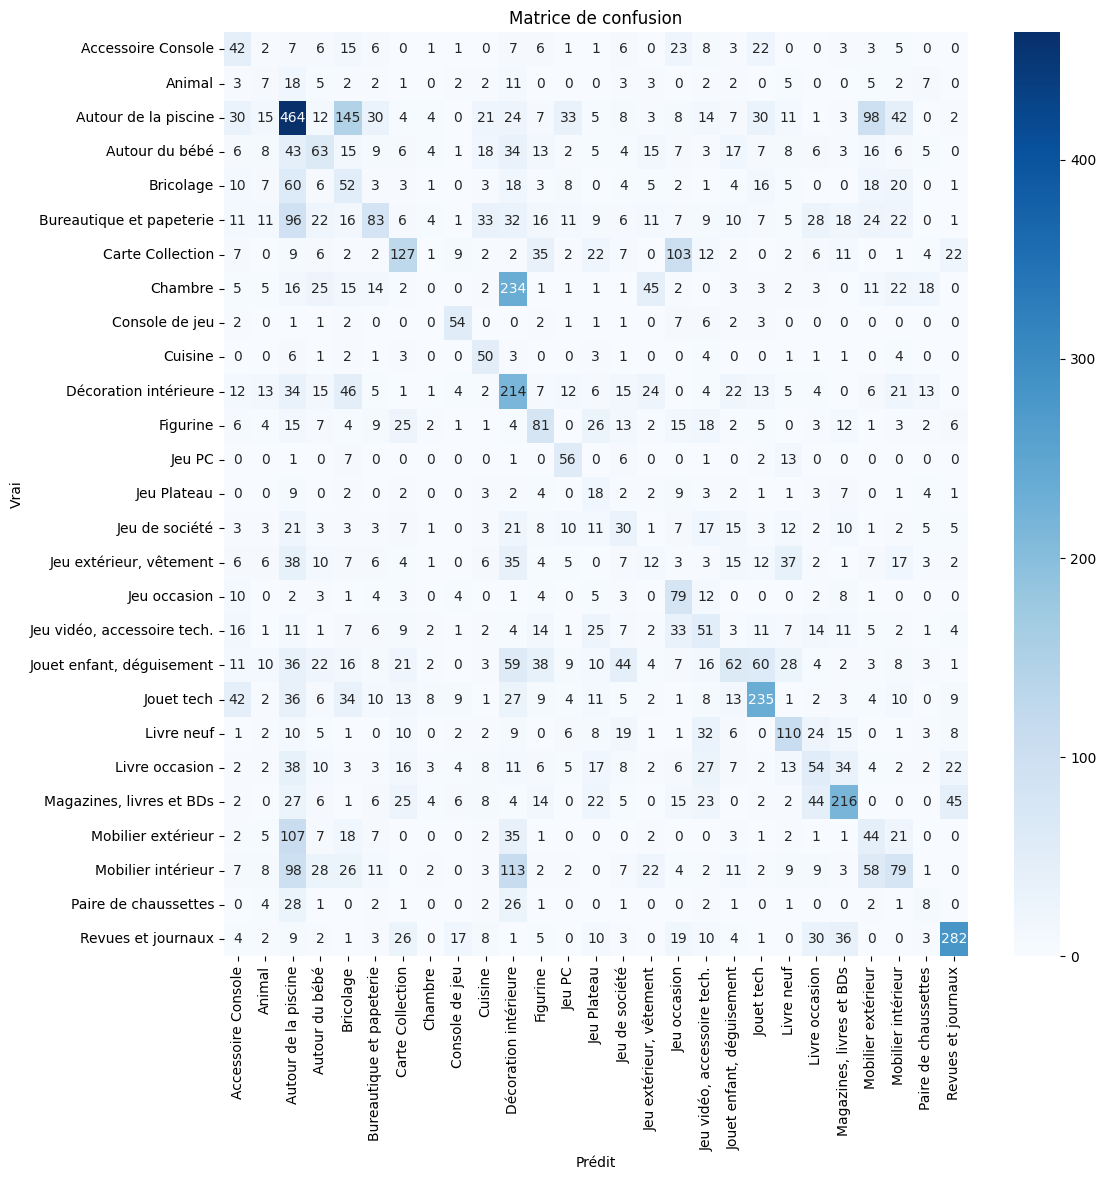

In [42]:
# Calculer le score du modèle
score = accuracy_score(y_test_visu, y_pred_visu)
print("Score du modèle :", score)

# Créer et afficher la matrice de confusion
mat_conf = pd.crosstab(y_test_visu, y_pred_visu)

plt.figure(figsize=(12, 12))
sns.heatmap(mat_conf, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion")
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.show()

In [43]:
print(classification_report(y_test_visu, y_pred_visu))

                             precision    recall  f1-score   support

         Accessoire Console       0.17      0.25      0.21       168
                     Animal       0.06      0.09      0.07        82
       Autour de la piscine       0.37      0.45      0.41      1021
             Autour du bébé       0.23      0.19      0.21       324
                  Bricolage       0.12      0.21      0.15       250
   Bureautique et papeterie       0.36      0.17      0.23       499
           Carte Collection       0.40      0.32      0.36       396
                    Chambre       0.00      0.00      0.00       431
             Console de jeu       0.47      0.65      0.54        83
                    Cuisine       0.27      0.62      0.38        81
      Décoration intérieure       0.23      0.43      0.30       499
                   Figurine       0.29      0.30      0.30       267
                     Jeu PC       0.33      0.64      0.44        87
                Jeu Plateau      

## SVM

### Entrainement du modèle svm

In [15]:
# X_train doit être un tableau numpy bidimensionnel
X_train_array = np.vstack(X_train_vectors)

In [17]:
# Création du modèle SVM avec des paramètres par défaut
model_svm = SVC()

# Entraînement du modèle avec les données d'entraînement
model_svm.fit(X_train_array, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC()

In [18]:
# X_test doit être un tableau numpy bidimensionnel
X_test_array = np.vstack(X_test_vectors)
# Faire des prédictions sur l'ensemble de test
y_pred_svm = model_svm.predict(np.array(X_test_vectors.tolist()))

### Résultats du SVM

Ajout des labels de classe pour visu

In [23]:
y_test_visu = y_test['prdtypecode'].map(prdcodetype2label)
y_pred_visu = [prdcodetype2label.get(code, "Label") for code in y_pred_svm]

Score du modèle : 0.7030146019783325


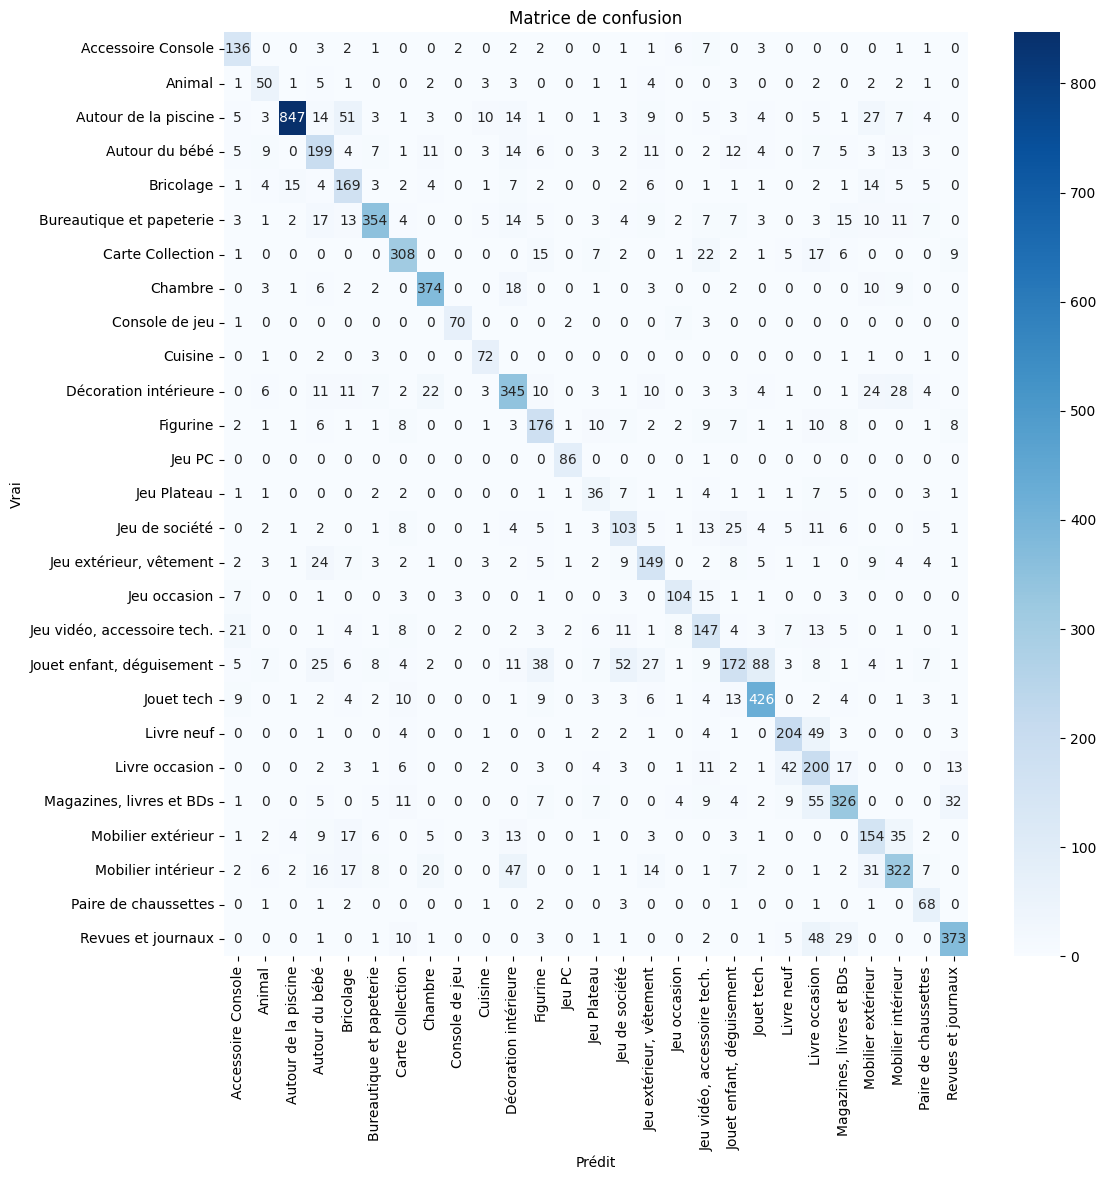

In [24]:
# Calculer le score du modèle
score = accuracy_score(y_test_visu, y_pred_visu)
print("Score du modèle :", score)

# Créer et afficher la matrice de confusion
mat_conf = pd.crosstab(y_test_visu, y_pred_visu)

plt.figure(figsize=(12, 12))
sns.heatmap(mat_conf, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de confusion")
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.show()

In [25]:
print(classification_report(y_test_visu, y_pred_visu))

                             precision    recall  f1-score   support

         Accessoire Console       0.67      0.81      0.73       168
                     Animal       0.50      0.61      0.55        82
       Autour de la piscine       0.97      0.83      0.89      1021
             Autour du bébé       0.56      0.61      0.58       324
                  Bricolage       0.54      0.68      0.60       250
   Bureautique et papeterie       0.84      0.71      0.77       499
           Carte Collection       0.78      0.78      0.78       396
                    Chambre       0.84      0.87      0.85       431
             Console de jeu       0.91      0.84      0.88        83
                    Cuisine       0.66      0.89      0.76        81
      Décoration intérieure       0.69      0.69      0.69       499
                   Figurine       0.60      0.66      0.63       267
                     Jeu PC       0.91      0.99      0.95        87
                Jeu Plateau      